# NumPy Basics: Stats, Normalization, and Smoothing

**Goal:** use NumPy arrays to implement the math-y parts of wrangling.

**You’ll do:**
- Compute descriptive stats and handle NaNs
- Normalize/standardize arrays
- Apply simple smoothing for noisy signals

## Demo arrays used in this notebook
We’ll use tiny NumPy arrays so the math is obvious and not buried in a DataFrame.

- `arr_nan`: numeric array with NaNs for Section 2
- `arr_clean`: clean numeric array (with one obvious outlier) for Section 3
- `signal_noisy`: simple increasing signal with noise for Section 5


## 1. Setup
- Import `numpy as np`.
- Assume we start from either a Pandas column (`df['col'].to_numpy()`) or a raw array `x`.

In [4]:
import os, sys, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
rng = np.random.default_rng(7)

# Section 2: stats with NaNs
arr_nan = np.array([42.0, 50.0, np.nan, 60.0, 70.0, np.nan, 55.0])

# Section 3: clean numeric with one outlier
arr_clean = np.array([1., 5., 10., 12., 14., 15., 20., 22., 25., 200.])  # 200 is an outlier

# Section 5: noisy signal for smoothing
x = np.linspace(0, 2*np.pi, 40)
signal_noisy = np.sin(x) + rng.normal(0, 0.15, size=x.size)
signal_noisy[10] = np.nan  # one missing sample to show handling
print("Demo arrays ready: arr_nan, arr_clean, signal_noisy")

Demo arrays ready: arr_nan, arr_clean, signal_noisy


## 2. Descriptive Stats with NaNs
---
**Dataset:** use `arr_nan` (a tiny 1D array) so the behavior is crystal clear.

**Use:** `np.nanmean`, `np.nanmedian`, `np.nanstd` for arrays containing NaNs.
- Plain `np.mean/median/std` will return `nan` if any NaN is present.
- The `nan*` versions compute while **ignoring** NaNs.


In [ ]:
# --- Section 2: Descriptive stats that ignore NaNs ---
print("[nan-aware stats on arr_nan]")
print(f"arr_nan: {arr_nan}\n")

print(f"np.mean      -> {np.mean(arr_nan)}")         # returns nan
print(f"np.nanmean   -> {np.nanmean(arr_nan)}\n")    # ignores NaN

print(f"np.median    -> {np.median(arr_nan)}")       # returns nan
print(f"np.nanmedian -> {np.nanmedian(arr_nan)}\n")  # ignores NaN

print(f"np.std       -> {np.std(arr_nan)}")          # returns nan
print(f"np.nanstd    -> {np.nanstd(arr_nan)}")       # ignores NaN

[nan-aware stats on arr_nan]
arr_nan: [42. 50. nan 60. 70. nan 55.]

np.mean      -> nan
np.nanmean   -> 55.4

np.median    -> nan
np.nanmedian -> 55.0

np.std       -> nan
np.nanstd    -> 9.414881836751857


In [ ]:
# --------------
# Handling NaNs: count 
# Fill with constants/mean, 
# Forward-fill 
# Interpolation
# --------------

# Count NaNs
nan_count = np.isnan(arr_nan).sum()
print(f"arr_nan: {arr_nan}")
print(f"NaN count: {nan_count}\n")

# Fill with 0
filled_zero = np.nan_to_num(arr_nan, nan=0.0)
print("[Fill NaNs with 0]")
print(filled_zero, "\n")

# Fill with mean
mu = np.nanmean(arr_nan)
filled_mean = np.nan_to_num(arr_nan, nan=mu)
print(f"[Fill NaNs with mean={mu:.2f}]")
print(filled_mean, "\n")

# Interpolation across gaps (linear)
arr_interp = arr_nan.copy()
mask = np.isnan(arr_interp)
if mask.any():
    idx = np.arange(arr_interp.size)
    arr_interp[mask] = np.interp(idx[mask], idx[~mask], arr_interp[~mask])
print("[Linear interpolation across NaNs]")
print(arr_interp, "\n")

# True forward-fill (carry last valid value)
arr_ffill = arr_nan.copy()
mask = np.isnan(arr_ffill)
idx = np.where(~mask, np.arange(arr_ffill.size), 0)
np.maximum.accumulate(idx, out=idx)
arr_ffill = arr_ffill[idx]
print("[Forward-fill NaNs (carry last valid)]")
print(arr_ffill)

arr_nan: [42. 50. nan 60. 70. nan 55.]
NaN count: 2

[Fill NaNs with 0]
[42. 50.  0. 60. 70.  0. 55.] 

[Fill NaNs with mean=55.40]
[42.  50.  55.4 60.  70.  55.4 55. ] 

[Linear interpolation across NaNs]
[42.  50.  55.  60.  70.  62.5 55. ] 

[Forward-fill NaNs (carry last valid)]
[42. 50. 50. 60. 70. 70. 55.]


## 3. Normalization & Standardization
---
**Dataset:** use `arr_clean` (1D array with an outlier) so effects are obvious.

**Formulas (NumPy algebra):**
- Min–max: `(x - x.min()) / (x.max() - x.min())`
- Z-score: `(x - x.mean()) / x.std()`
- Robust (median/Median Absolute Deviation): `(x - median) / MAD` where `MAD = median(|x - median|)`

> How do outliers influence our normalization & standardization methods?

In [20]:
# --------------
# Normalization/Standardization
# --------------

x = arr_clean.copy()
print("Original:", x)

# Min–max
x_min, x_max = x.min(), x.max()
x_minmax = (x - x_min) / (x_max - x_min)
print("\n[Min–max scaling]")
print(x_minmax)

# Z-score
mu, sigma = x.mean(), x.std()
x_z = (x - mu) / sigma
print("\n[Z-score standardization]")
print(x_z)

# Robust scaling (median/MAD)
med = np.median(x)
mad = np.median(np.abs(x - med))
x_robust = (x - med) / mad
print("\n[Robust scaling: median/MAD]")
print(x_robust)

# Quick sanity checks
print(f"\nmean(z-score)≈{x_z.mean():.3f}, std(z-score)≈{x_z.std():.3f}")
print(f"median(robust)≈{np.median(x_robust):.3f}, MAD used={mad:.3f}")

Original: [  1.   5.  10.  12.  14.  15.  20.  22.  25. 200.]

[Min–max scaling]
[0.         0.0201005  0.04522613 0.05527638 0.06532663 0.07035176
 0.09547739 0.10552764 0.12060302 1.        ]

[Z-score standardization]
[-0.55767808 -0.48663629 -0.39783405 -0.36231315 -0.32679225 -0.3090318
 -0.22022956 -0.18470866 -0.13142732  2.97665117]

[Robust scaling: median/MAD]
[-2.07692308 -1.46153846 -0.69230769 -0.38461538 -0.07692308  0.07692308
  0.84615385  1.15384615  1.61538462 28.53846154]

mean(z-score)≈0.000, std(z-score)≈1.000
median(robust)≈0.000, MAD used=6.500


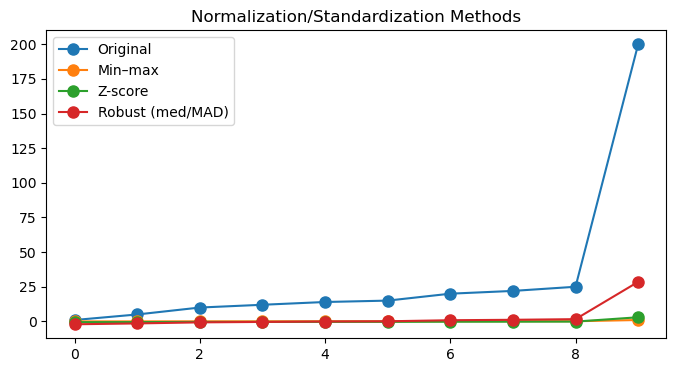

In [21]:
# Plot unsclaed vs scaled arrays
plt.figure(figsize=(8,4))
plt.plot(x, 'o-', label='Original', markersize=8)
plt.plot(x_minmax, 'o-', label='Min–max', markersize=8)
plt.plot(x_z, 'o-', label='Z-score', markersize=8)
plt.plot(x_robust, 'o-', label='Robust (med/MAD)', markersize=8)
plt.title('Normalization/Standardization Methods')
plt.legend()
plt.show()

## 4. Clipping and Winsorizing (array-only)
- Clip: `np.clip(x, a_min, a_max)` to bound absurd values before modeling
- Winsorize idea: replace extreme tails with boundary values (manual with percentiles)

> Exercise: compute p1 and p99 using `np.percentile` and winsorize manually.

## 5. Smoothing / Noise Reduction
---
**Dataset:** use `signal_noisy` (noisy sine wave) to show the effect without plots.

- Simple moving average (SMA) with window `k` using 1D convolution
- Exponential moving average (EMA) with decay `alpha`
- Handle NaNs first so filters don't propagate missing values.

In [16]:
# --------------
# Smoothing a noisy 1D signal
# --------------

# Implementation for simple moving average assisted by NumPy ops
def sma(y, k):
    kernel = np.ones(k) / k
    return np.convolve(y, kernel, mode="valid")

# Implementation for exponential moving average assisted by NumPy ops
def ema(y, alpha=0.2):
    out = np.empty_like(y)
    out[0] = y[0]
    for t in range(1, len(y)):
        out[t] = alpha * y[t] + (1 - alpha) * out[t-1]
    return out

# Handle a NaN in the signal by linear interpolation so filters don't propagate NaNs
interp_s = signal_noisy.copy()
mask = np.isnan(interp_s)
if mask.any():
    idx = np.arange(interp_s.size)
    interp_s[mask] = np.interp(idx[mask], idx[~mask], interp_s[~mask])
   
# Generate smoothes arrays 
sma_s = sma(interp_s, k=5)
ema_s = ema(interp_s, alpha=0.2)

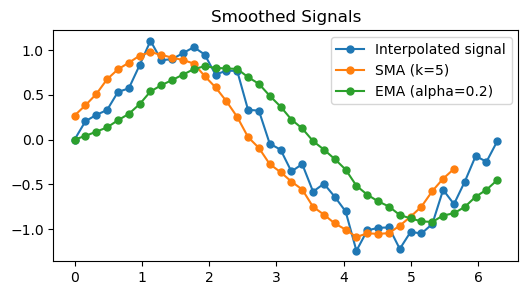

In [18]:
# Smoothed plots in a single plot
plt.figure(figsize=(6, 3))
plt.plot(x, interp_s, 'o-', label='Interpolated signal', markersize=5)
plt.plot(x[:len(sma_s)], sma_s, 'o-', label='SMA (k=5)', markersize=5)
plt.plot(x, ema_s, 'o-', label='EMA (alpha=0.2)', markersize=5)
plt.title('Smoothed Signals')
plt.legend()
plt.show()

## 6. Matrix Ops You’ll Actually Use
- Broadcasting rules to combine vectors and columns
- Fast distance computations: `(A[:,None] - B[None,:])**2` then `sum(axis=-1)`
- Batch transforms: apply scaling to 2D arrays column-wise with broadcasting

**Takeaways**
- NumPy = low-level, predictable performance.
- Handle NaNs explicitly or your stats lie.